# HDBSCAN Clustering for RBD sequences
---
### DEMO
https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#sphx-glr-auto-examples-cluster-plot-hdbscan-py
--- 
### Parquet Making
We will be making a parquet for the entire file. Then we can sample from it randomly.

Merging the metadata with the sequence data.

In [12]:
import os
import pandas as pd

data_dir = "../../data/rbd"

csv_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.csv")
df = pd.read_csv(csv_file, header=0, low_memory=False)
df

,seq_id,sequence,variant
0,EPI_ISL_5120698,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta
1,EPI_ISL_5123727,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta
2,EPI_ISL_14904955,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
3,EPI_ISL_5119677,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta
4,EPI_ISL_14904971,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
...,...,...,...
347427,EPI_ISL_14903692,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
347428,EPI_ISL_14902388,RVQPTESIVRFPNITNLCPFDEVFNATTFASVYAWNRKRISNCVAD...,Omicron
347429,EPI_ISL_14905423,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
347430,EPI_ISL_5123715,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta


In [13]:
meta_data = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.tsv")
metadata_df = pd.read_csv(meta_data, sep='\t', header=0, low_memory=False)
metadata_df = metadata_df.rename(columns={'Accession ID': 'seq_id'})
metadata_df = metadata_df[['seq_id', 'Pango lineage', 'Location', 'Collection date', 'AA Substitutions']]

merged_df = pd.merge(df, metadata_df, on='seq_id', how='left')

print(merged_df['variant'].value_counts())
merged_df.head(5)

variant
Omicron    160016
Delta      109448
UNKNOWN     40917
Alpha       22075
Gamma        5978
Iota         2044
Epsilon      1915
Beta         1342
Lambda        985
Mu            939
Eta           611
Zeta          578
Kappa         505
GH/490R        57
Theta          22
Name: count, dtype: int64


,seq_id,sequence,variant,Pango lineage,Location,Collection date,AA Substitutions
0,EPI_ISL_5120698,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta,B.1.617.2,Europe / Germany / Berlin,2021-10-06,"(NSP1_V54del,NSP3_A1321del,N_G215C,NSP3_S1314d..."
1,EPI_ISL_5123727,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta,AY.4,Europe / United Kingdom / England,2021-10-08,"(N_G215C,NSP3_A1711V,Spike_T95I,N_D63G,N_R203M..."
2,EPI_ISL_14904955,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron,BA.5.5,North America / USA / Maryland,2022-08-22,"(NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d..."
3,EPI_ISL_5119677,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta,AY.126,Europe / Germany / Lower Saxony,2021-09-30,"(N_G215C,Spike_T95I,N_D63G,N_R203M,NSP12_G671S..."
4,EPI_ISL_14904971,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron,BA.5.6,North America / USA / California,2022-08-22,"(NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d..."


In [14]:
ado_df = merged_df[merged_df['variant'].isin(["Alpha", "Delta", "Omicron"])]
save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv")
ado_df.to_csv(save_as, index=False)
ado_df['variant'].value_counts()

variant
Omicron    160016
Delta      109448
Alpha       22075
Name: count, dtype: int64

Making the parquet.

In [15]:
import os
import sys
import torch
import time
import datetime
import pandas as pd
from torch.utils.data import Dataset, DataLoader

from transformers import EsmTokenizer, EsmModel 

import lightning as L

# Parquet Making
class RBDDataset(Dataset):
    """ BetaCorona virus sequence dataset, embedded with ESM model. """

    def __init__(self, csv_file:str):
        try:
            self.df = pd.read_csv(csv_file, sep=',', header=0, na_filter=False)
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            print(f"Error reading in .csv file: {csv_file}\n{e}", file=sys.stderr)
            sys.exit(1)

        self.max_len = self.df['sequence'].apply(len).max()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        columns = (
            self.df.iloc[idx]["seq_id"],
            self.df.iloc[idx]["variant"],
            self.df.iloc[idx]["Pango lineage"],
            self.df.iloc[idx]["Location"],
            self.df.iloc[idx]["Collection date"],
            self.df.iloc[idx]["AA Substitutions"],
            self.df.iloc[idx]["sequence"],
        )
        return columns

class RBDDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int, num_workers: int, seed: int):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed

        # Set seeds globally for reproducibility
        L.seed_everything(self.seed, workers=True)

    def setup(self, stage):
        # Called on every GPU
        if stage == 'test':
            self.test_dataset = RBDDataset(os.path.join(self.data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv"))

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            drop_last=False, 
            num_workers=self.num_workers,
            generator=torch.Generator().manual_seed(self.seed),
            pin_memory=True
        )

class LightningProteinEsmEmbedder(L.LightningModule):
    def __init__(self, max_len: int, csv_file:str, esm_version="facebook/esm2_t6_8M_UR50D", from_esm_mlm=None):
        super().__init__()
        self.tokenizer = EsmTokenizer.from_pretrained(esm_version, cache_dir="../../.cache")
        self.model = EsmModel.from_pretrained(esm_version, cache_dir="../../.cache")
        self.from_esm_mlm = from_esm_mlm
        self.max_len = max_len
        self.csv_file = csv_file
        self.batch_dataframes = []

        # Load fine-tuned weights from Lightning ESM_MLM ckpt
        if from_esm_mlm is not None:
            if trainer.global_rank == 0: print(f"Loading ESM_MLM checkpoint from {from_esm_mlm}...")

            ckpt = torch.load(from_esm_mlm, map_location="cpu")
            state_dict = ckpt["state_dict"]

            # Remove "model." prefix and filter out EsmMaskedLM specific keys
            new_state_dict = {}
            for key, value in state_dict.items():
                # Remove "model." prefix
                new_key = key.replace("model.esm.", "model.")

                # Filter out EsmMaskedLM keys (e.g., lm_head.*)
                if "lm_head" not in new_key:
                    new_state_dict[new_key] = value

            # Load weights non-strictly
            missing, unexpected = self.load_state_dict(new_state_dict, strict=False)

            # Define keys to ignore in missing list, these won't exist in the ESM_MLM
            ignored_missing = {
                'model.pooler.dense.weight', 'model.pooler.dense.bias'
            }

            # Filter out ignored missing keys
            filtered_missing = [k for k in missing if k not in ignored_missing]

            # Raise error if any unexpected keys are missing
            if filtered_missing: raise RuntimeError(f"Missing unexpected keys from ESM_MLM checkpoint: {filtered_missing}")

            if trainer.global_rank == 0:
                print("ESM_MLM checkpoint loaded successfully.")

                if unexpected: print("Unexpected keys:", unexpected)

    def forward(self, input_ids, attention_mask):
        esm_last_hidden_state = self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state # shape: [batch_size, sequence_length, embedding_dim]
        esm_cls_embedding = esm_last_hidden_state[:, 0, :]  # CLS token embedding (sequence-level representations), [batch_size, embedding_dim]
        return esm_cls_embedding

    def test_step(self, batch, batch_idx):
        seq_ids, variants, pango_lineages, locations, collection_dates, aa_subs, seqs = batch 

        tokenized_seqs = self.tokenizer(seqs, return_tensors="pt", padding=True, truncation=True, max_length=self.max_len)
        tokenized_seqs = {k: v.to(self.device) for k, v in tokenized_seqs.items()}

        cls_embeddings = self(input_ids=tokenized_seqs["input_ids"], attention_mask=tokenized_seqs["attention_mask"])

        # Create a DataFrame for the batch
        batch_df = pd.DataFrame({
            "seq_id": seq_ids,
            "variant": variants,
            "Pango lineage": pango_lineages,
            "Location": locations,
            "Collection date": collection_dates,
            "AA Substitutions": aa_subs,
            "embedding": [embedding.detach().cpu().numpy() for embedding in cls_embeddings]  # Convert tensor to numpy array for each embedding
        })

        self.batch_dataframes.append(batch_df)

    def on_test_epoch_end(self):
        # Concatenate all batch DataFrames into one
        result_df = pd.concat(self.batch_dataframes, ignore_index=True)
    
        # Save data to a Parquet file
        save_as = self.csv_file.replace(".csv", f"{'_from-esm-mlm' if self.from_esm_mlm is not None else ''}_CLS-embedded.parquet")
        result_df.to_parquet(save_as, index=False)
        print(f"Data saved to {save_as}.")

seed = 0
L.seed_everything(seed)  # Set seed for reproducibility
data_dir = "../../data/rbd"

# Trainer setup 
trainer= L.Trainer(
    limit_test_batches=1.0, # 1.0 is 100% of batches 
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    num_nodes=1,
    devices=1,
    logger=False,
    enable_progress_bar=True
)

# Initialize DataModule and model
dm = RBDDataModule(
    data_dir = data_dir,
    batch_size = 64,
    num_workers = 4, 
    seed = seed
)
dm.setup("test")

model = LightningProteinEsmEmbedder(
    max_len = dm.test_dataset.max_len + 2, # Account for CLS, EOS tokens
    csv_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv"),
    esm_version = "facebook/esm2_t6_8M_UR50D",
    from_esm_mlm = "best_model-epoch=73.val_loss=0.0022.val_accuracy=99.6612.ckpt"
)

start_time = time.perf_counter()
trainer.test(model, dm)  # Test model
duration = datetime.timedelta(seconds=time.perf_counter()-start_time)
print(f"[Timing] Test.fit(...) took: {duration} (hh:mm:ss).")

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
Seed set to 0
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading ESM_MLM checkpoint from best_model-epoch=73.val_loss=0.0022.val_accuracy=99.6612.ckpt...
ESM_MLM checkpoint loaded successfully.


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing DataLoader 0: 100%|██████████| 4556/4556 [04:06<00:00, 18.50it/s]
[Timing] Test.fit(...) took: 0:04:09.206127 (hh:mm:ss).


---

### Clustering - tSNE, then HDBSCAN
Sampling from the embeddings.

In [16]:
parquet_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_from-esm-mlm_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Random sampling
min_sample_size = embedded_ado_df['variant'].value_counts().min()
sample_sizes = {"Alpha": min_sample_size,
                "Delta": min_sample_size,
                "Omicron": min_sample_size}

rnd_seed = 0
sampled_dfs = [embedded_ado_df[embedded_ado_df['variant'] == variant].sample(n=sample_sizes[variant], random_state=rnd_seed)
                           for variant in sample_sizes.keys()]
    
sampled_ado_df = pd.concat(sampled_dfs)
print(sampled_ado_df['variant'].value_counts())

save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_from-esm-mlm_CLS-embedded.sampled.parquet")
sampled_ado_df.to_parquet(save_as, index=False)

variant
Alpha      22075
Delta      22075
Omicron    22075
Name: count, dtype: int64


Apply tSNE to the embeddings, then save the tSNE embeddings.

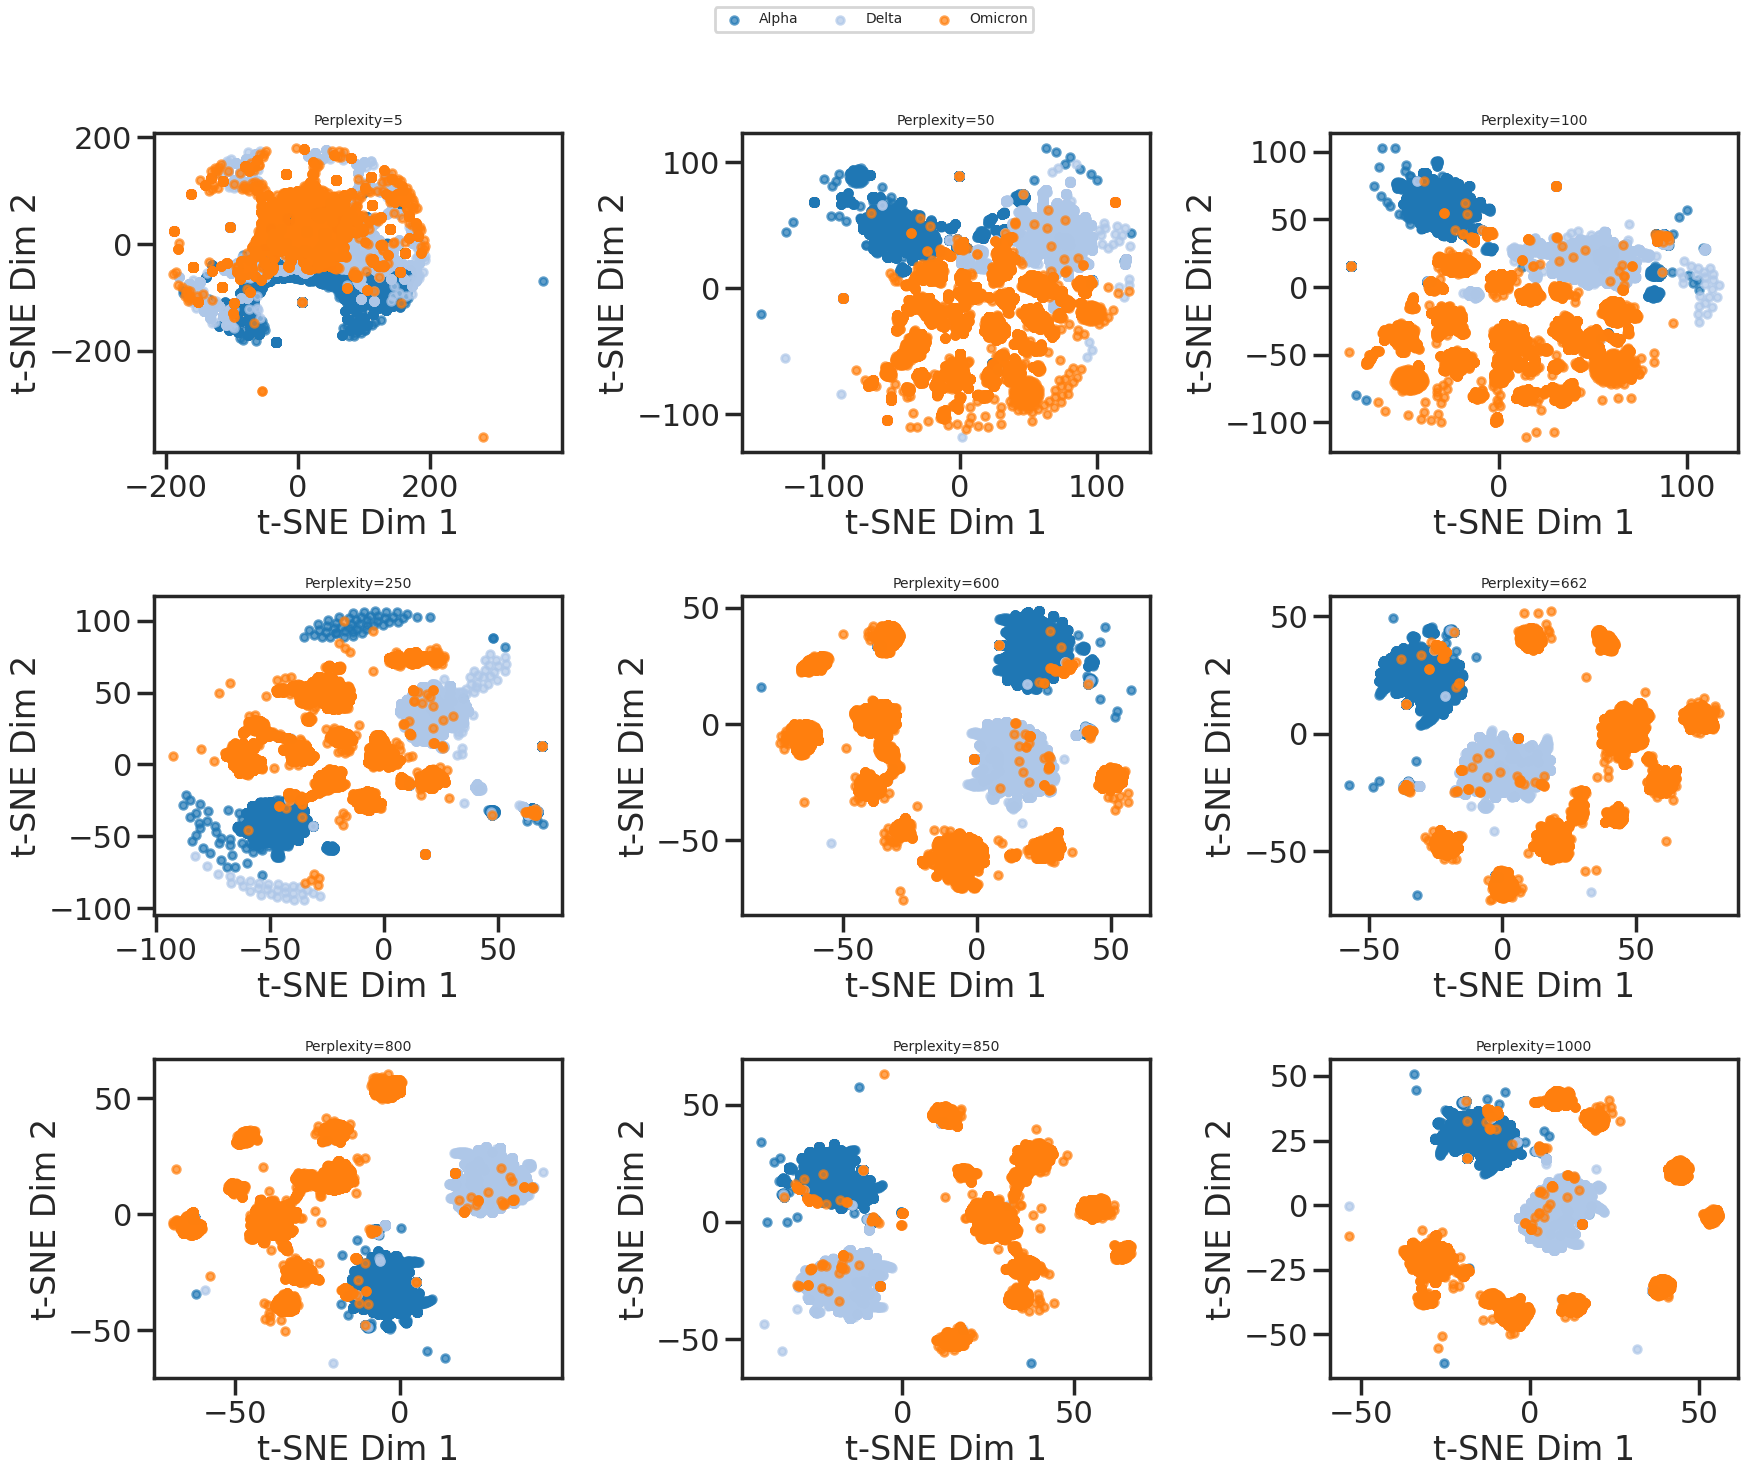

In [17]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne_grid(info_df, embedding_matrix, variant_column, color_map='tab20', perplexities=[5, 50, 100, 250, 600, 662, 800, 850, 1000]):
    n_rows = 3
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 15))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.rcParams['font.family'] = 'sans-serif'

    variant_labels = sorted(info_df[variant_column].unique())
    colors = sns.color_palette(color_map, len(variant_labels))
    variant_colors = dict(zip(variant_labels, colors))
    variant_colors['UNSPECIFIED'] = 'black'

    for ax, perp in zip(axes.flat, perplexities):
        tsne = TSNE(n_components=2, perplexity=perp, random_state=0)
        embedding = tsne.fit_transform(embedding_matrix)
        embeddings_df = pd.DataFrame(embedding, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
        df = pd.concat([info_df, embeddings_df], axis=1)
        df['colors'] = df[variant_column].map(variant_colors)

        for variant in variant_labels:
            subset = df[df[variant_column] == variant]
            ax.scatter(subset['DIM_1'], subset['DIM_2'], 
                       label=variant, c=[variant_colors[variant]], s=30, alpha=0.7)

        ax.set_title(f'Perplexity={perp}', fontsize=10)
        ax.set_xlabel('t-SNE Dim 1')
        ax.set_ylabel('t-SNE Dim 2')

    # Only show legend once in a free axis or the last axis
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Load in the data
data_dir = "../../data/rbd"
parquet_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_from-esm-mlm_CLS-embedded.sampled.parquet")
embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_df["embedding"])
info_df = embedded_df.drop(columns=["embedding"])

# Apply tSNE to reduce the dimensionality of the embedding matrix
plot_tsne_grid(info_df, embedding_matrix, variant_column='variant')

In [ ]:
# Save the embedding based off best perplexity
perplexity = 850
tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)

embeddings_df = pd.DataFrame(embedding_matrix_reduced, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
tsne_df = pd.concat([info_df, embeddings_df], axis=1)
save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_from-esm-mlm_CLS-embedded.sampled.tsne-perp{perplexity}.parquet")
tsne_df.to_parquet(save_as, engine='fastparquet')

Load the tSNE embeddings.

In [2]:
import os
import pandas as pd

# Load the embedding
perplexity = 850
data_dir = "../../data/rbd"
parquet_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_from-esm-mlm_CLS-embedded.sampled.tsne-perp{perplexity}.parquet")
embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix_reduced = embedded_df[['DIM_1', 'DIM_2']].values
info_df = embedded_df.drop(columns=['DIM_1', 'DIM_2'])

Find highest or a sufficiently highest Silhouette Coefficient, Adjusted Rand Index.

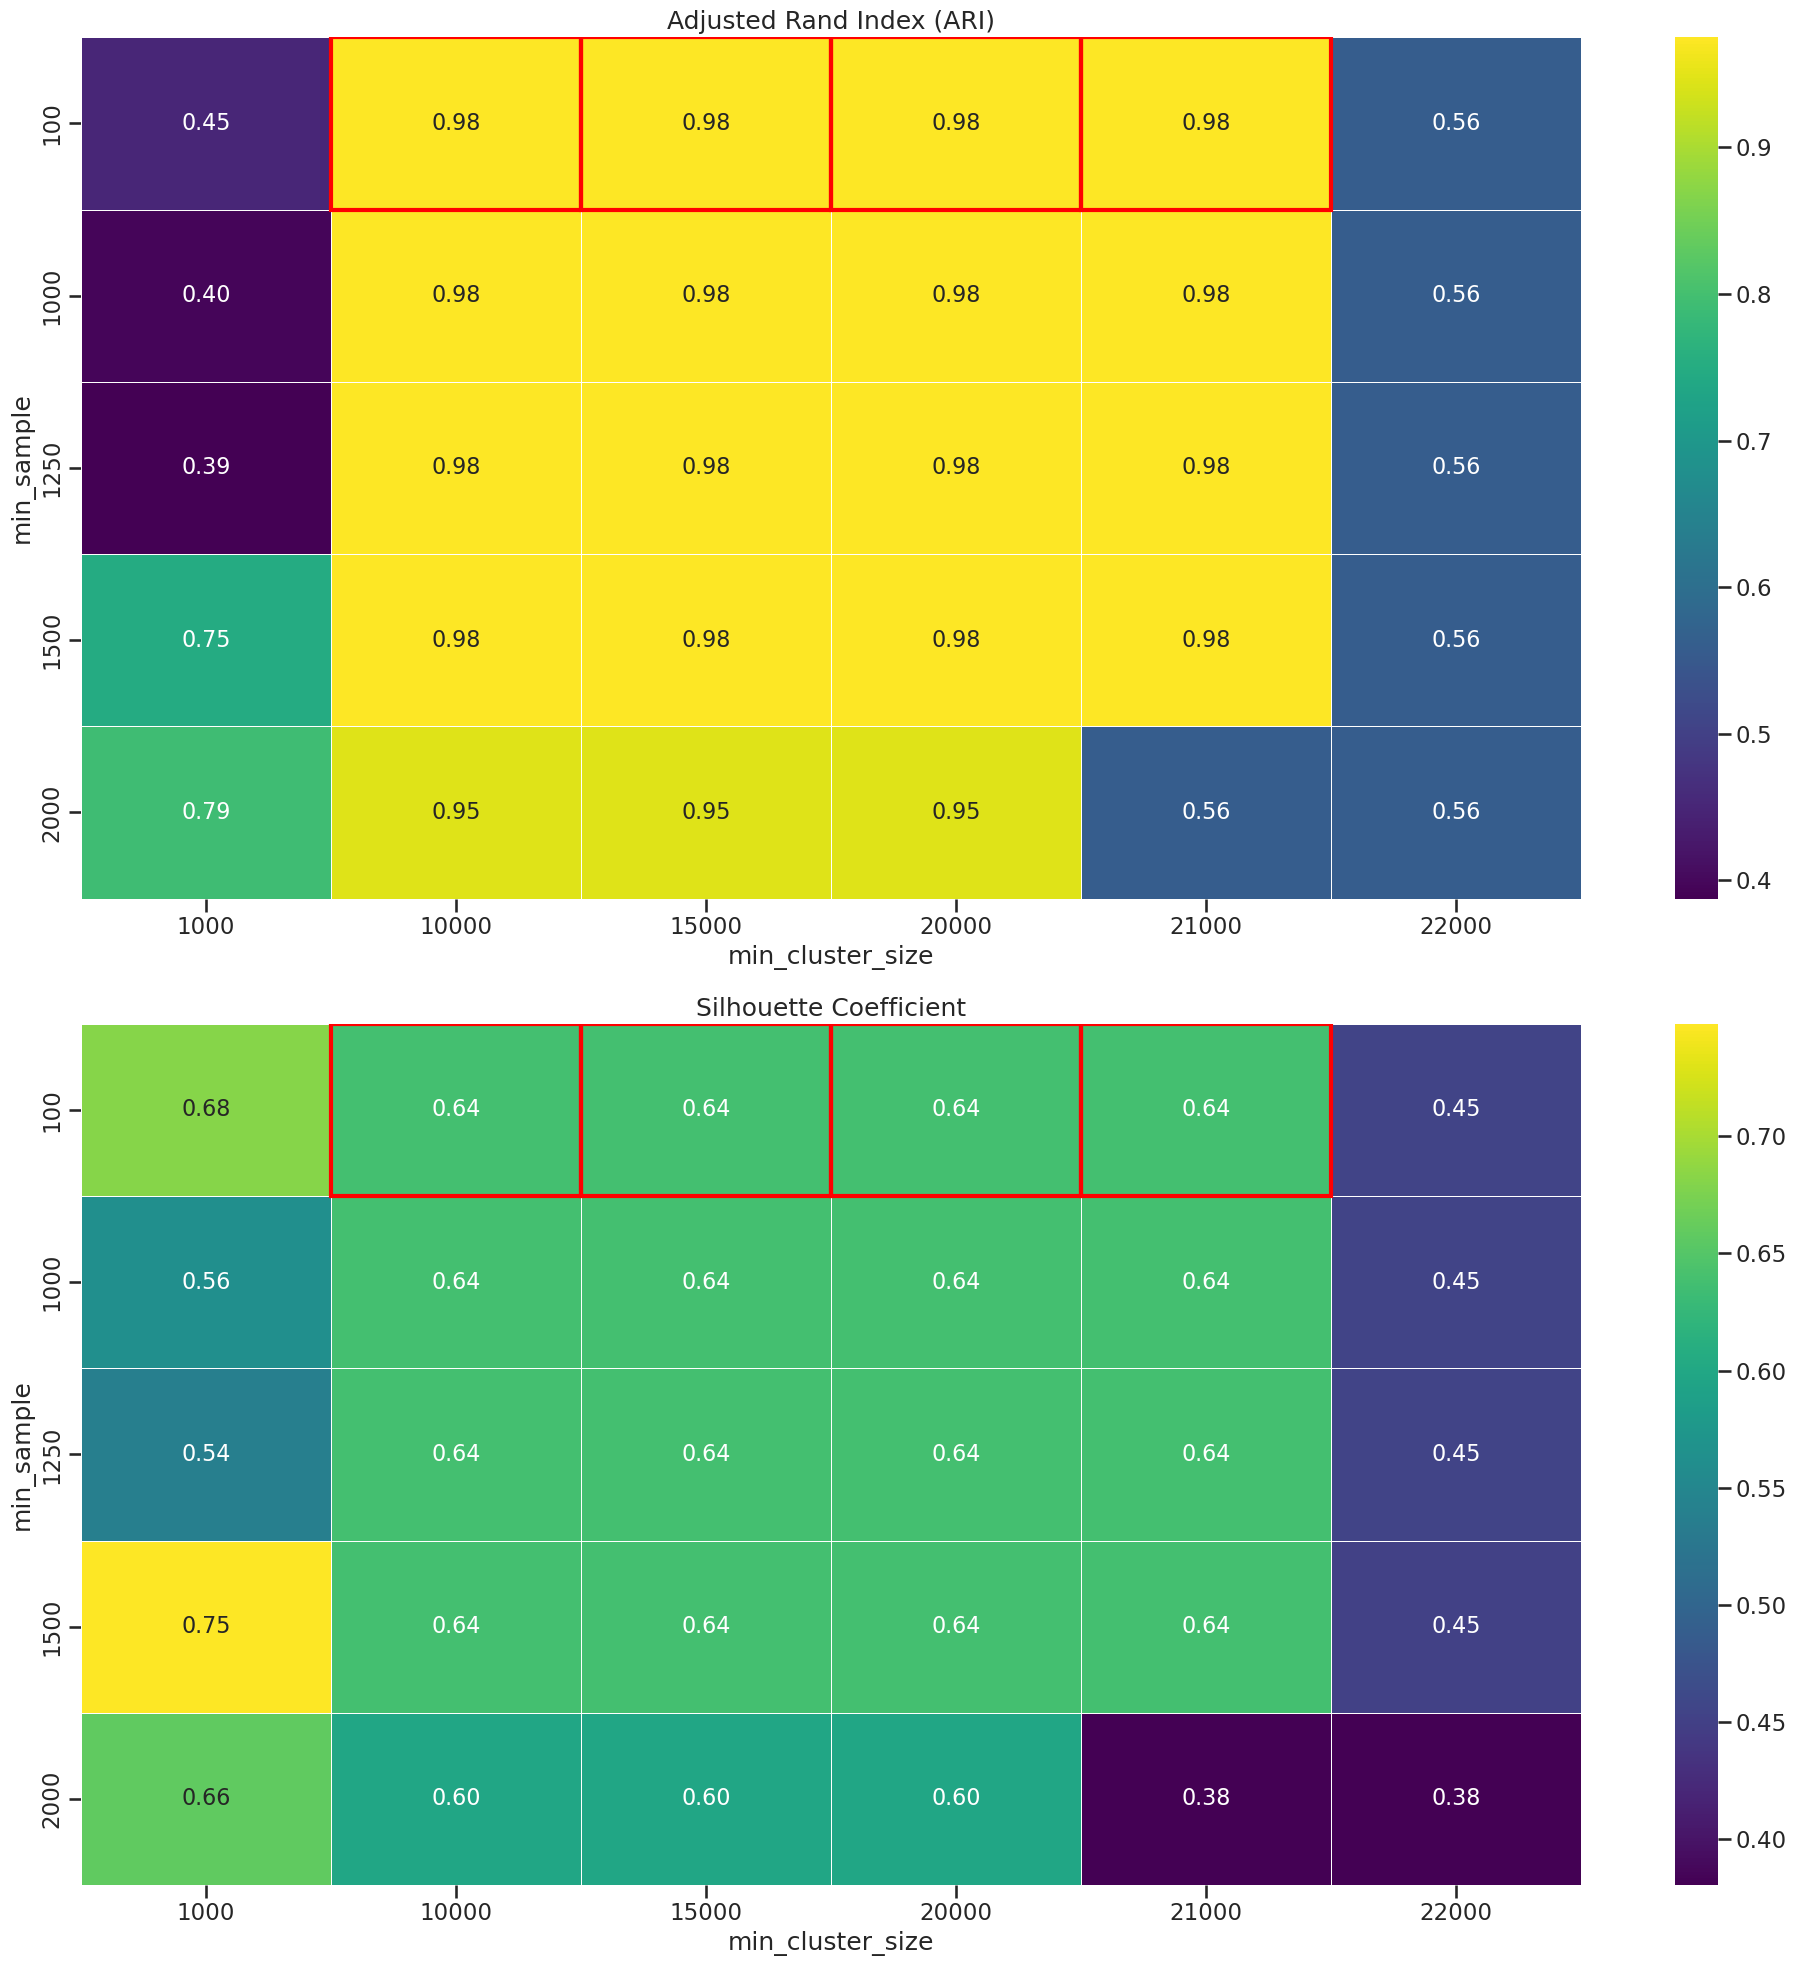

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def ari_sc_heatmap(embedding_matrix_reduced, info_df):
    results = []

    for ms in [100, 1000, 1500, 1250, 2000]:
        for mcs in [1000, 10000, 15000, 20000, 21000, 22000]:
            # Cluster
            clusterer = hdbscan.HDBSCAN(
                min_samples=ms,
                min_cluster_size=mcs,
                core_dist_n_jobs=-1
            ).fit(embedding_matrix_reduced)

            labels = clusterer.labels_

            # Evaluate clustering
            ari = adjusted_rand_score(info_df["variant"], labels)

            # Check number of clusters (excluding noise)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1:
                silhouette_avg = silhouette_score(embedding_matrix_reduced, labels)
            else:
                silhouette_avg = np.nan  # or 0, depending on how you want to treat it

            # Store results
            results.append({
                "min_sample": ms,
                "min_cluster_size": mcs,
                "ari": ari,
                "silhouette": silhouette_avg
            })

    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Pivot matrices
    ari_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='ari')
    silhouette_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='silhouette')

    # Plot heatmaps
    sns.set_style('ticks')
    sns.set_context("talk")
    fig, axs = plt.subplots(2, 1, figsize=(20, 20))

    sns.heatmap(ari_matrix, annot=True, annot_kws={"size": 16}, fmt=".2f", linewidth=.5, cmap="viridis", ax=axs[0])
    axs[0].set_title("Adjusted Rand Index (ARI)")
    axs[0].set_xlabel("min_cluster_size")
    axs[0].set_ylabel("min_sample")

    max_ari = ari_matrix.max().max()  # Get the max ARI value

    for i in range(ari_matrix.shape[0]):  # min_sample (rows)
        for j in range(ari_matrix.shape[1]):  # min_cluster_size (cols)
            if np.isclose(ari_matrix.iloc[i, j], max_ari):  # Safe float comparison
                axs[0].add_patch(
                    plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3)
                )

    sns.heatmap(silhouette_matrix, annot=True, annot_kws={"size": 16}, fmt=".2f", linewidth=.5, cmap="viridis", ax=axs[1])
    axs[1].set_title("Silhouette Coefficient")
    axs[1].set_xlabel("min_cluster_size")
    axs[1].set_ylabel("min_sample")

    for i in range(ari_matrix.shape[0]):  # min_sample (rows)
        for j in range(ari_matrix.shape[1]):  # min_cluster_size (cols)
            if np.isclose(ari_matrix.iloc[i, j], max_ari):  # Safe float comparison
                axs[1].add_patch(
                    plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3)
                )
    plt.tight_layout()
    plt.show()

ari_sc_heatmap(embedding_matrix_reduced, info_df)

- 800: 0.96, 0.65 (1000, 10000)
- 850: 0.98, 0.64 (100, 10000)

Plotting the tSNE embeddings after applying HDBSCAN.

min_sample 100, min_cluster_size 10000: Adjusted Rand Index: 0.98, Silhouette Coefficient: 0.64


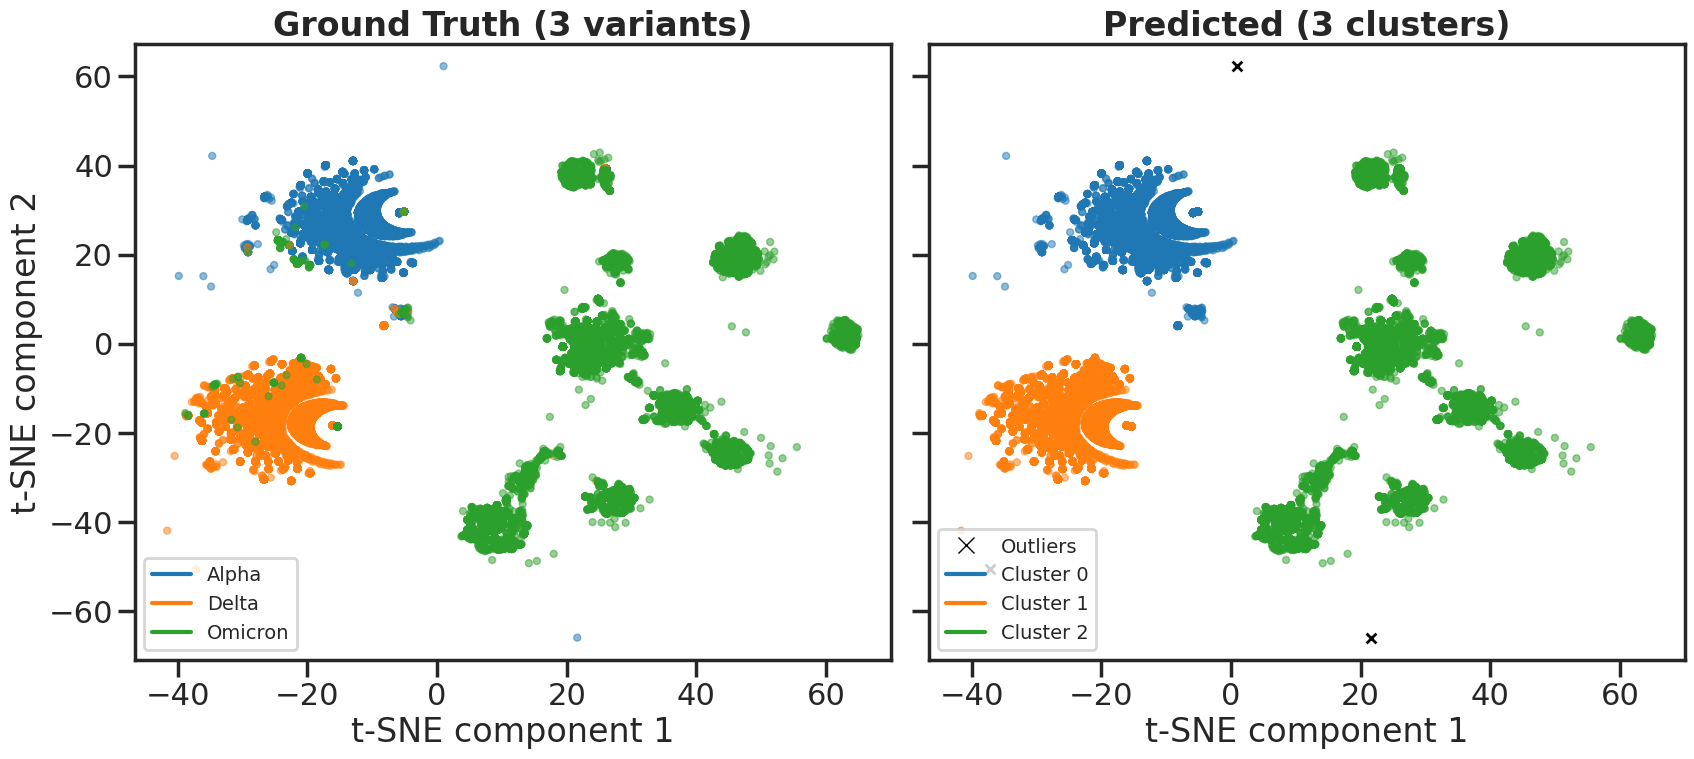

Predicted Clusters,-1,0,1,2
Ground Truth,,,,
Alpha,0.01,99.54,0.25,0.20
Delta,0.00,0.74,99.14,0.11
Omicron,0.00,0.86,0.34,98.80


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score

def plot_groundtruth_prediction_1x2(embedding_matrix, info_df, hdb_labels, save_as, x_min_width_buffer=2, colormap="colorblind"):
    # Create a DataFrame for easier plotting
    plot_df = pd.DataFrame({
        't-SNE component 1': embedding_matrix[:, 0],
        't-SNE component 2': embedding_matrix[:, 1],
        'Cluster': hdb_labels,
        'Seq ID': info_df['seq_id'],
        'Variant': info_df['variant'],
    })
    marker_size = 25
    
    # Define a variant color palette
    unique_variants = np.unique(plot_df['Variant'])
    variant_color_palette = sns.color_palette(colormap, n_colors=len(unique_variants)) 
    variant_color_dict = {label: color for label, color in zip(unique_variants, variant_color_palette)}

    # Define a cluster color palette
    unique_clusters = np.unique(plot_df['Cluster'])
    cluster_color_palette = sns.color_palette(colormap, n_colors=len(unique_clusters)) 
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_color_palette)}
    cluster_color_dict[-1] = 'black'  # Set outliers to x

    sns.set_style('ticks')
    sns.set_context("poster")
    fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    fig.subplots_adjust(wspace=0.05)  # Reduce the horizontal space between subplots

    #####################################################

    # Scatterplot
    sns.scatterplot(
        data=plot_df,
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Variant', palette=variant_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1,
        ax=axs[0]
    )

    axs[0].set_title(f"Ground Truth ({len(unique_variants)} variants)", ha='center', fontweight='bold')
    axs[0].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+5))
    axs[0].set_ylim(plot_df['t-SNE component 2'].min()-5, plot_df['t-SNE component 2'].max()+5),

    # Legend 
    variant_handles = [
        plt.Line2D([0], [0], color=variant_color_dict[variant], label=f'{variant}')
        for variant in unique_variants
    ]
    axs[0].legend(handles=variant_handles)
    sns.move_legend(axs[0], "lower left", fontsize=14)
    
    # #####################################################

    # Scatterplot for non-outliers
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] != -1],  # Exclude outliers
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Cluster', palette=cluster_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1,
        ax=axs[1]
    )

    # Scatterplot for outliers (Cluster = -1)
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] == -1],  # Select only outliers
        x='t-SNE component 1', y='t-SNE component 2',
        marker='x',
        s=marker_size*2, color='black', linewidth=2,
        ax=axs[1]
    )

    axs[1].set_title(f"Predicted ({len(unique_clusters[unique_clusters != -1])} clusters)", ha='center', fontweight='bold')
    axs[1].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+5))

    # Legend 
    cluster_handles = [plt.Line2D([0], [0], marker='x', color='black', linestyle='none', label='Outliers')]
    cluster_handles += [
        plt.Line2D([0], [0], color=cluster_color_dict[cluster], label=f'Cluster {cluster}')
        for cluster in unique_clusters if cluster != -1
    ]
    axs[1].legend(handles=cluster_handles)
    sns.move_legend(axs[1], "lower left", fontsize=14)

    #####################################################
  
    plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_as}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

min_samples=100
min_cluster_size=10000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Adjusted Rand Index: {ari:.2f}, Silhouette Coefficient: {silhouette_avg:.2f}")
save_as = f"RBD.ADO.from-esm-mlm.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-ari{ari:.2f}_sc{silhouette_avg:.2f}"

# Call the function
plot_groundtruth_prediction_1x2(embedding_matrix_reduced, info_df, hdb_labels, save_as, x_min_width_buffer=5, colormap="tab10")

# Create the truth table
truth_table_percent = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'],
                                normalize='index')  # Normalize along the index (rows)
truth_table_percent = (truth_table_percent * 100).round(2)
truth_table_percent

min_sample 100, min_cluster_size 10000: Adjusted Rand Index: 0.98, Silhouette Coefficient: 0.64


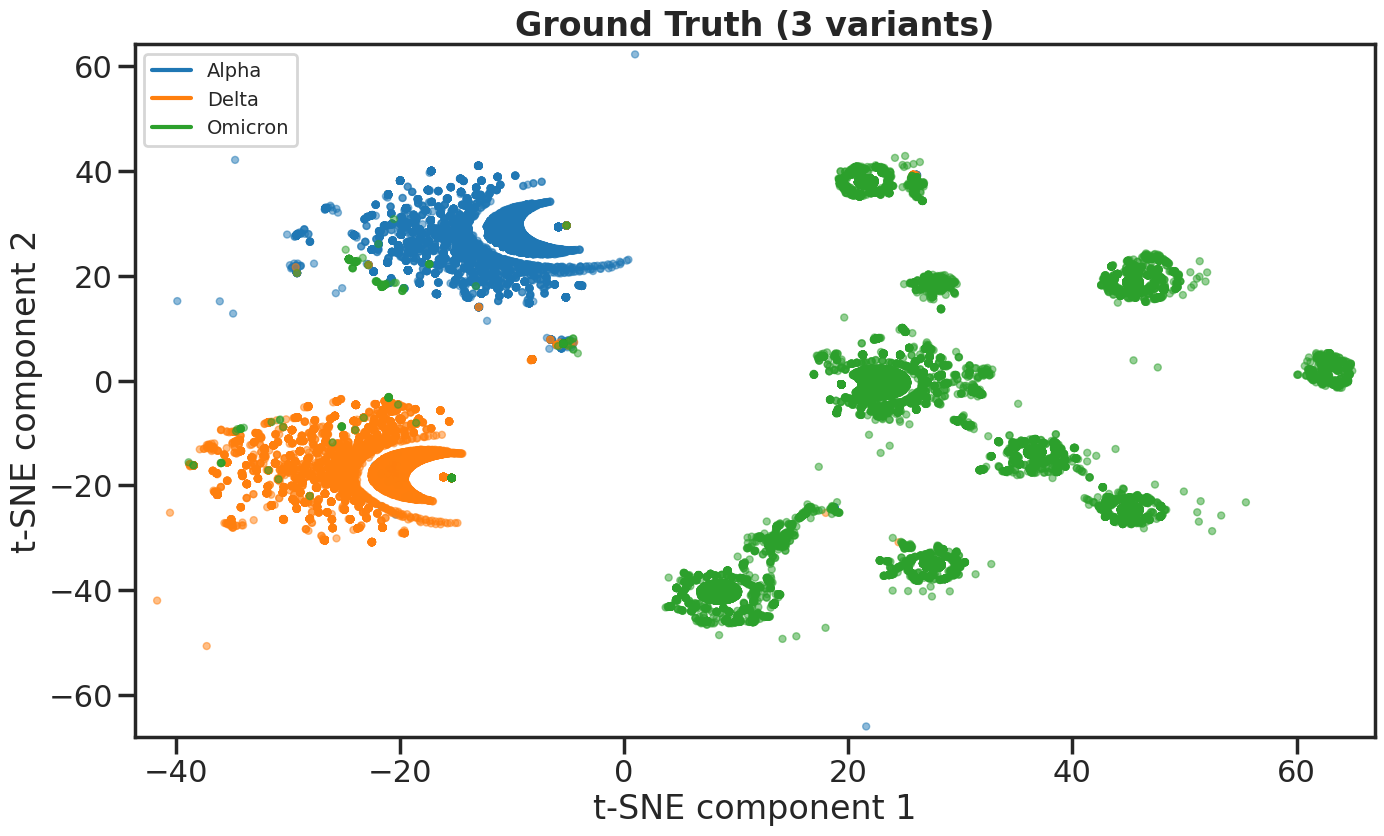

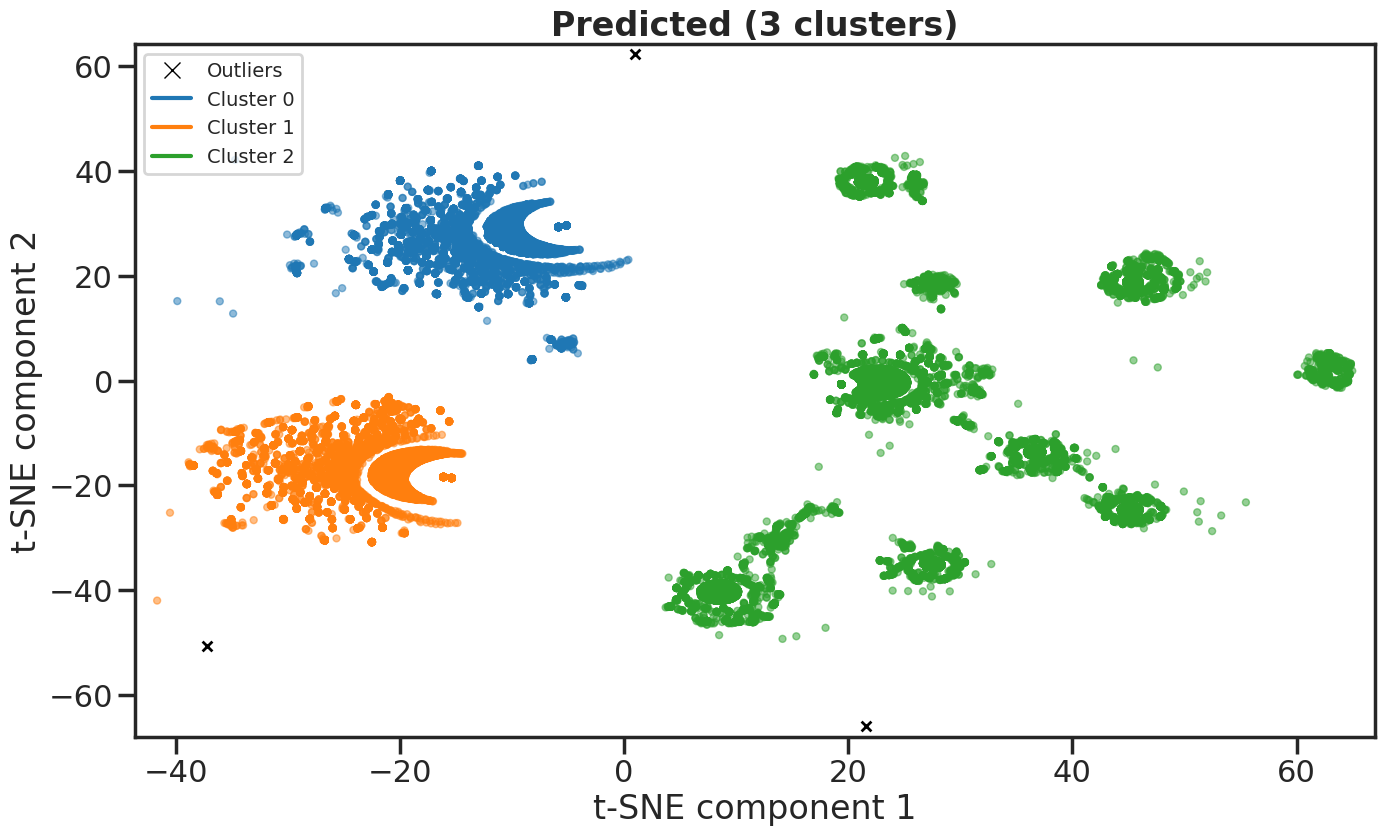

Predicted Clusters,-1,0,1,2
Ground Truth,,,,
Alpha,0.01,99.54,0.25,0.20
Delta,0.00,0.74,99.14,0.11
Omicron,0.00,0.86,0.34,98.80


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score

def plot_ground_truth(embedding_matrix, info_df, hdb_labels, save_as, x_min_width_buffer=2, colormap="colorblind"):
    # Create a DataFrame for easier plotting
    plot_df = pd.DataFrame({
        't-SNE component 1': embedding_matrix[:, 0],
        't-SNE component 2': embedding_matrix[:, 1],
        'Cluster': hdb_labels,
        'Seq ID': info_df['seq_id'],
        'Variant': info_df['variant'],
    })
    marker_size = 25

    # Define a variant color palette
    unique_variants = np.unique(plot_df['Variant'])
    variant_color_palette = sns.color_palette(colormap, n_colors=len(unique_variants)) 
    variant_color_dict = {label: color for label, color in zip(unique_variants, variant_color_palette)}

    sns.set_style('ticks')
    sns.set_context("poster")
    fig, ax = plt.subplots(figsize=(16, 9))

    #####################################################

    # Scatterplot
    sns.scatterplot(
        data=plot_df,
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Variant', palette=variant_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1
    )

    ax.set_title(f"Ground Truth ({len(unique_variants)} variants)", ha='center', fontweight='bold')
    ax.set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+2))
    ax.set_ylim(plot_df['t-SNE component 2'].min()-2, plot_df['t-SNE component 2'].max()+2),

    # Legend 
    variant_handles = [
        plt.Line2D([0], [0], color=variant_color_dict[variant], label=f'{variant}')
        for variant in unique_variants
    ]
    ax.legend(handles=variant_handles)
    sns.move_legend(ax, "upper left", fontsize=14)

    #####################################################
  
    plt.savefig(f"{save_as}.ground_truth_only.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_as}.ground_truth_only.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_prediction(embedding_matrix, info_df, hdb_labels, save_as, x_min_width_buffer=2, colormap="colorblind"):
    # Create a DataFrame for easier plotting
    plot_df = pd.DataFrame({
        't-SNE component 1': embedding_matrix[:, 0],
        't-SNE component 2': embedding_matrix[:, 1],
        'Cluster': hdb_labels,
        'Seq ID': info_df['seq_id'],
        'Variant': info_df['variant'],
    })
    marker_size = 25

    # Define a cluster color palette
    unique_clusters = np.unique(plot_df['Cluster'])
    cluster_color_palette = sns.color_palette(colormap, n_colors=len(unique_clusters)) 
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_color_palette)}
    cluster_color_dict[-1] = 'black'  # Set outliers to x

    sns.set_style('ticks')
    sns.set_context("poster")
    fig, ax = plt.subplots(figsize=(16, 9))

    #####################################################

    # Scatterplot for non-outliers
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] != -1],  # Exclude outliers
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Cluster', palette=cluster_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1,
    )

    # Scatterplot for outliers (Cluster = -1)
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] == -1],  # Select only outliers
        x='t-SNE component 1', y='t-SNE component 2',
        marker='x',
        s=marker_size*2, color='black', linewidth=2,
    )

    ax.set_title(f"Predicted ({len(unique_clusters[unique_clusters != -1])} clusters)", ha='center', fontweight='bold')
    ax.set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+2))
    ax.set_ylim(plot_df['t-SNE component 2'].min()-2, plot_df['t-SNE component 2'].max()+2),

    # Legend 
    cluster_handles = [plt.Line2D([0], [0], marker='x', color='black', linestyle='none', label='Outliers')]
    cluster_handles += [
        plt.Line2D([0], [0], color=cluster_color_dict[cluster], label=f'Cluster {cluster}')
        for cluster in unique_clusters if cluster != -1
    ]
    ax.legend(handles=cluster_handles)
    sns.move_legend(ax, "upper left", fontsize=14)

    #####################################################
  
    plt.savefig(f"{save_as}.prediction_only.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_as}.prediction_only.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

min_samples=100
min_cluster_size=10000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Adjusted Rand Index: {ari:.2f}, Silhouette Coefficient: {silhouette_avg:.2f}")
save_as = f"RBD.ADO.from-esm-mlm.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-ari{ari:.2f}_sc{silhouette_avg:.2f}"

# Call the function
plot_ground_truth(embedding_matrix_reduced, info_df, hdb_labels, save_as, x_min_width_buffer=2, colormap="tab10")
plot_prediction(embedding_matrix_reduced, info_df, hdb_labels, save_as, x_min_width_buffer=2, colormap="tab10")

# Create the truth table
truth_table_percent = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'],
                                normalize='index')  # Normalize along the index (rows)
truth_table_percent = (truth_table_percent * 100).round(2)
truth_table_percent

In [32]:
import matplotlib.dates as mdates

def cluster_date_collected(save_as, info_df, hdb_labels, colormap):
    """ Calculate variant percentages over collection dates within clusters and plot them in a single plot. """
    
    # Copy the DataFrame to avoid modifying the original
    df = info_df.copy()

    # Define cluster color mapping, with outliers (Cluster -1) as black
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette(colormap, n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    if len(sns.color_palette(colormap)) < (len(unique_clusters)-1):
        cluster_colors = sns.color_palette(colormap) + sns.color_palette(["#999933", "#882255", "#661100", "#6699CC", "#332288"])
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are gray

    # Ensure 'Collection date' is a datetime object
    df['Collection date'] = pd.to_datetime(df['Collection date'], format='mixed')

    # Aggregate data by counting variants for each collection date (by year and month)
    df['YearMonth'] = df['Collection date'].dt.to_period('M')
    cluster_date_counts = df.groupby(['Cluster', 'YearMonth', 'variant']).size().reset_index(name='Cluster count')

    # Calculate total count within each cluster
    total_cluster_count = df.groupby(['Cluster']).size().reset_index(name='Total count')
    cluster_date_counts = cluster_date_counts.merge(total_cluster_count, on='Cluster')

    # Calculate percentages within each cluster
    cluster_date_counts['Cluster %'] = (cluster_date_counts['Cluster count'] / cluster_date_counts['Total count']) * 100

    # Sort by 'Cluster' and 'YearMonth'
    cluster_date_counts = cluster_date_counts.sort_values(by=['Cluster', 'YearMonth'], ascending=[True, True])

    # Create a single plot with all clusters and variants
    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=(16, 9))

    # Plot each cluster-variant pair in the same plot, applying color mapping
    for (cluster_label, variant), grouped_df in cluster_date_counts.groupby(['Cluster', 'variant']):
        ax.plot(grouped_df['YearMonth'].dt.to_timestamp(), 
                grouped_df['Cluster %'], 
                label=f"Cluster {cluster_label}",
                color=cluster_color_dict[cluster_label],  # Apply cluster-specific color
                linewidth=3)

    fontsize = 20
    ax.set_xlabel('Collection Date', fontsize=fontsize)
    ax.set_ylabel(f'Percentage (%)', fontsize=fontsize)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.legend(loc='upper right', fontsize=fontsize-6, bbox_to_anchor=(1, 1))

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(save_as + ".timescale.pdf", format="pdf")
    plt.savefig(save_as + ".timescale.png", format="png")
    plt.show()

def cluster_pango_lineage(info_df, top_x=None):
    """ Calculate Pango lineage percentages within clusters and select top x for each cluster. """
    
    # Copy the DataFrame to avoid modifying the original
    df = info_df.copy()

    # Truncate Pango lineage to the first two parts if needed
    trunc_format = lambda x: f"{'.'.join(x.split('.')[:3])}*" if len(x.split('.')) >= 3 else x
    df['Pango lineage'] = df['Pango lineage'].apply(trunc_format)

    # Calculate lineage counts within each cluster
    cluster_counts = df.groupby(['Cluster', 'variant', 'Pango lineage']).size().reset_index(name='Cluster count')

    # Calculate total counts for each lineage across the entire dataset
    total_counts = df.groupby('Pango lineage').size().reset_index(name='Total count')

    # Merge the cluster counts with total counts
    lineage_counts = pd.merge(cluster_counts, total_counts, on='Pango lineage', how='left')

    # Calculate the 'Cluster %' and 'Lineage %'
    lineage_counts['Cluster %'] = (lineage_counts['Cluster count'] / lineage_counts.groupby('Cluster')['Cluster count'].transform('sum')) * 100
    lineage_counts['Lineage %'] = (lineage_counts['Cluster count'] / lineage_counts['Total count']) * 100

    # Sort by 'cluster' and then by 'Cluster %' within each cluster
    lineage_counts = lineage_counts.sort_values(by=['Cluster', 'Cluster %'], ascending=[True, False])
    lineage_counts = lineage_counts.drop(columns=['Cluster count', 'Total count'])

    # Select top x lineages for each cluster
    if top_x != None:
        top_lineages_per_cluster = lineage_counts.groupby('Cluster').head(top_x)
        return top_lineages_per_cluster.reset_index(drop=True)
    else:
        return lineage_counts.reset_index(drop=True)

def split_dataframe_by_cluster(df):
    """ Split the DataFrame into separate DataFrames by cluster. """
    
    # Create a dictionary to store DataFrames for each cluster
    cluster_dfs = {}
    
    # Group the DataFrame by 'cluster' and iterate over each group
    for cluster, group in df.groupby('Cluster'):
        # Store each group as a separate DataFrame in the dictionary
        cluster_dfs[cluster] = group.reset_index(drop=True)
    
    return cluster_dfs

# Cluster info
info_df['Cluster'] = hdb_labels
result = cluster_pango_lineage(info_df, 5)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

   Cluster variant Pango lineage  Cluster %  Lineage %
0       -1   Alpha        B.1.1*  66.666667   0.009236
1       -1   Delta       AY.4.2*  33.333333   0.128205

   Cluster  variant Pango lineage  Cluster %   Lineage %
0        0    Alpha        B.1.1*  96.058584   99.039483
1        0    Alpha           Q.3   0.868903   99.487179
2        0    Alpha           Q.1   0.541945  100.000000
3        0    Alpha           Q.4   0.506114   97.413793
4        0  Omicron    Unassigned   0.165719    4.347826

   Cluster variant Pango lineage  Cluster %  Lineage %
0        1   Delta          AY.4  13.104106  99.757953
1        1   Delta      B.1.617*   7.194767  98.691589
2        1   Delta        AY.122   6.399891  97.915219
3        1   Delta        AY.103   5.573219  98.871878
4        1   Delta         AY.43   4.660247  99.130435

   Cluster  variant Pango lineage  Cluster %   Lineage %
0        2  Omicron       BA.5.2*   9.589104   99.809705
1        2  Omicron          BA.2   8.693268  

### Without the from_esm_mlm set:

In [18]:
seed = 0
L.seed_everything(seed)  # Set seed for reproducibility
data_dir = "../../data/rbd"

# Trainer setup 
trainer= L.Trainer(
    limit_test_batches=1.0, # 1.0 is 100% of batches 
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    num_nodes=1,
    devices=1,
    logger=False,
    enable_progress_bar=True
)

# Initialize DataModule and model
dm = RBDDataModule(
    data_dir = data_dir,
    batch_size = 64,
    num_workers = 4, 
    seed = seed
)
dm.setup("test")

model = LightningProteinEsmEmbedder(
    max_len = dm.test_dataset.max_len + 2, # Account for CLS, EOS tokens
    csv_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv"),
    esm_version = "facebook/esm2_t6_8M_UR50D"
)

start_time = time.perf_counter()
trainer.test(model, dm)  # Test model
duration = datetime.timedelta(seconds=time.perf_counter()-start_time)
print(f"[Timing] Test.fit(...) took: {duration} (hh:mm:ss).")

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
Seed set to 0
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing DataLoader 0: 100%|██████████| 4556/4556 [04:21<00:00, 17.39it/s]
[Timing] Test.fit(...) took: 0:04:25.371928 (hh:mm:ss).


In [19]:
parquet_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Random sampling
min_sample_size = embedded_ado_df['variant'].value_counts().min()
sample_sizes = {"Alpha": min_sample_size,
                "Delta": min_sample_size,
                "Omicron": min_sample_size}

rnd_seed = 0
sampled_dfs = [embedded_ado_df[embedded_ado_df['variant'] == variant].sample(n=sample_sizes[variant], random_state=rnd_seed)
                           for variant in sample_sizes.keys()]
    
sampled_ado_df = pd.concat(sampled_dfs)
print(sampled_ado_df['variant'].value_counts())

save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.sampled.parquet")
sampled_ado_df.to_parquet(save_as, index=False)

variant
Alpha      22075
Delta      22075
Omicron    22075
Name: count, dtype: int64


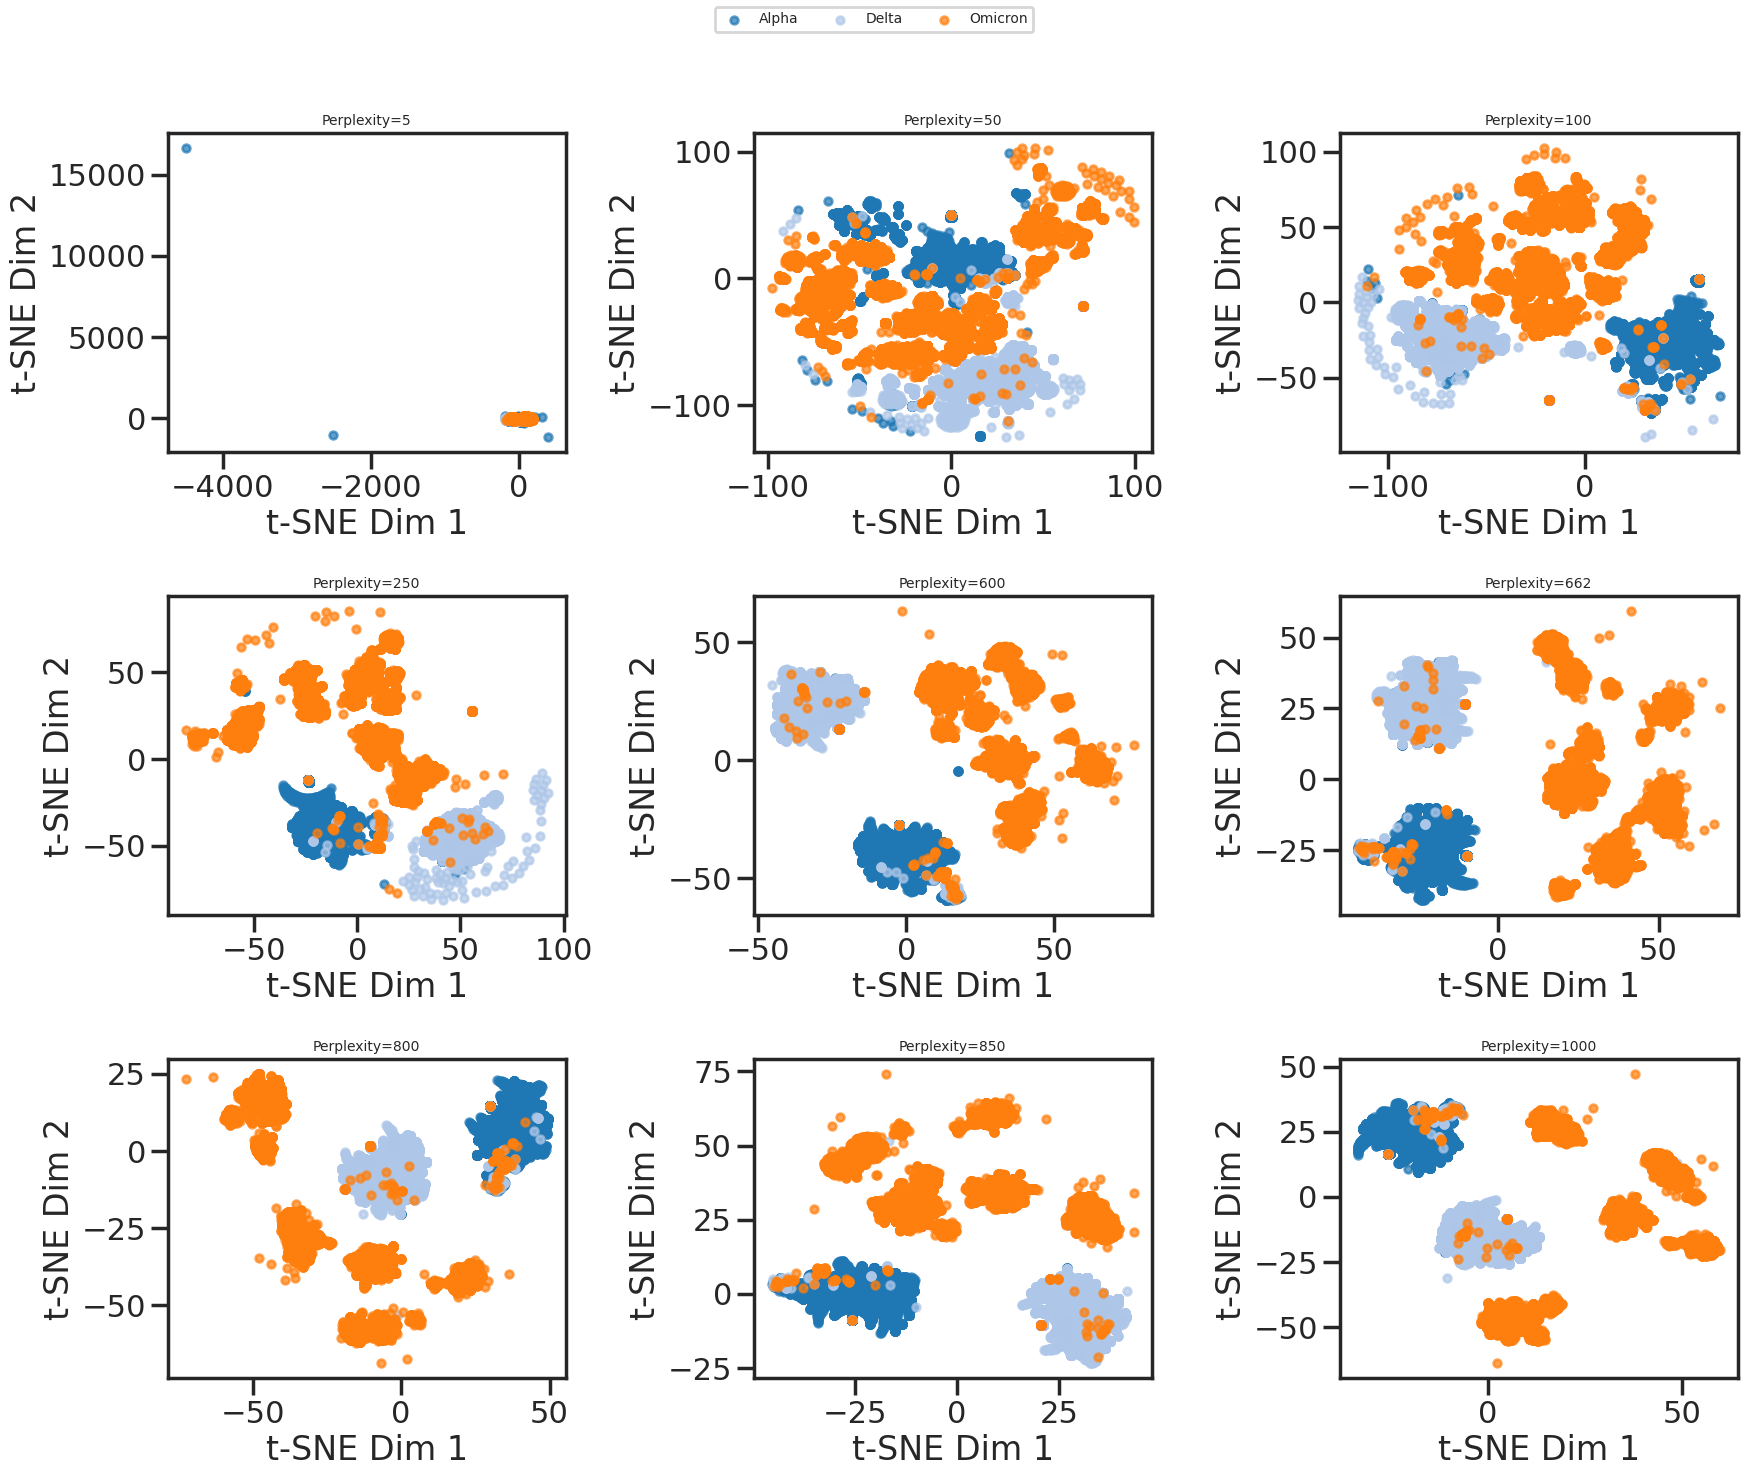

In [20]:
# Load in the data
data_dir = "../../data/rbd"
parquet_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.sampled.parquet")
embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_df["embedding"])
info_df = embedded_df.drop(columns=["embedding"])

# Apply tSNE to reduce the dimensionality of the embedding matrix
plot_tsne_grid(info_df, embedding_matrix, variant_column='variant')

In [3]:
# Save the embedding based off best perplexity
perplexity = 600
tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)

embeddings_df = pd.DataFrame(embedding_matrix_reduced, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
tsne_df = pd.concat([info_df, embeddings_df], axis=1)
save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.sampled.tsne-perp{perplexity}.parquet")
tsne_df.to_parquet(save_as, engine='fastparquet')

In [22]:
# Load the embedding
parquet_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.sampled.tsne-perp{perplexity}.parquet")
embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix_reduced = embedded_df[['DIM_1', 'DIM_2']].values
info_df = embedded_df.drop(columns=['DIM_1', 'DIM_2'])

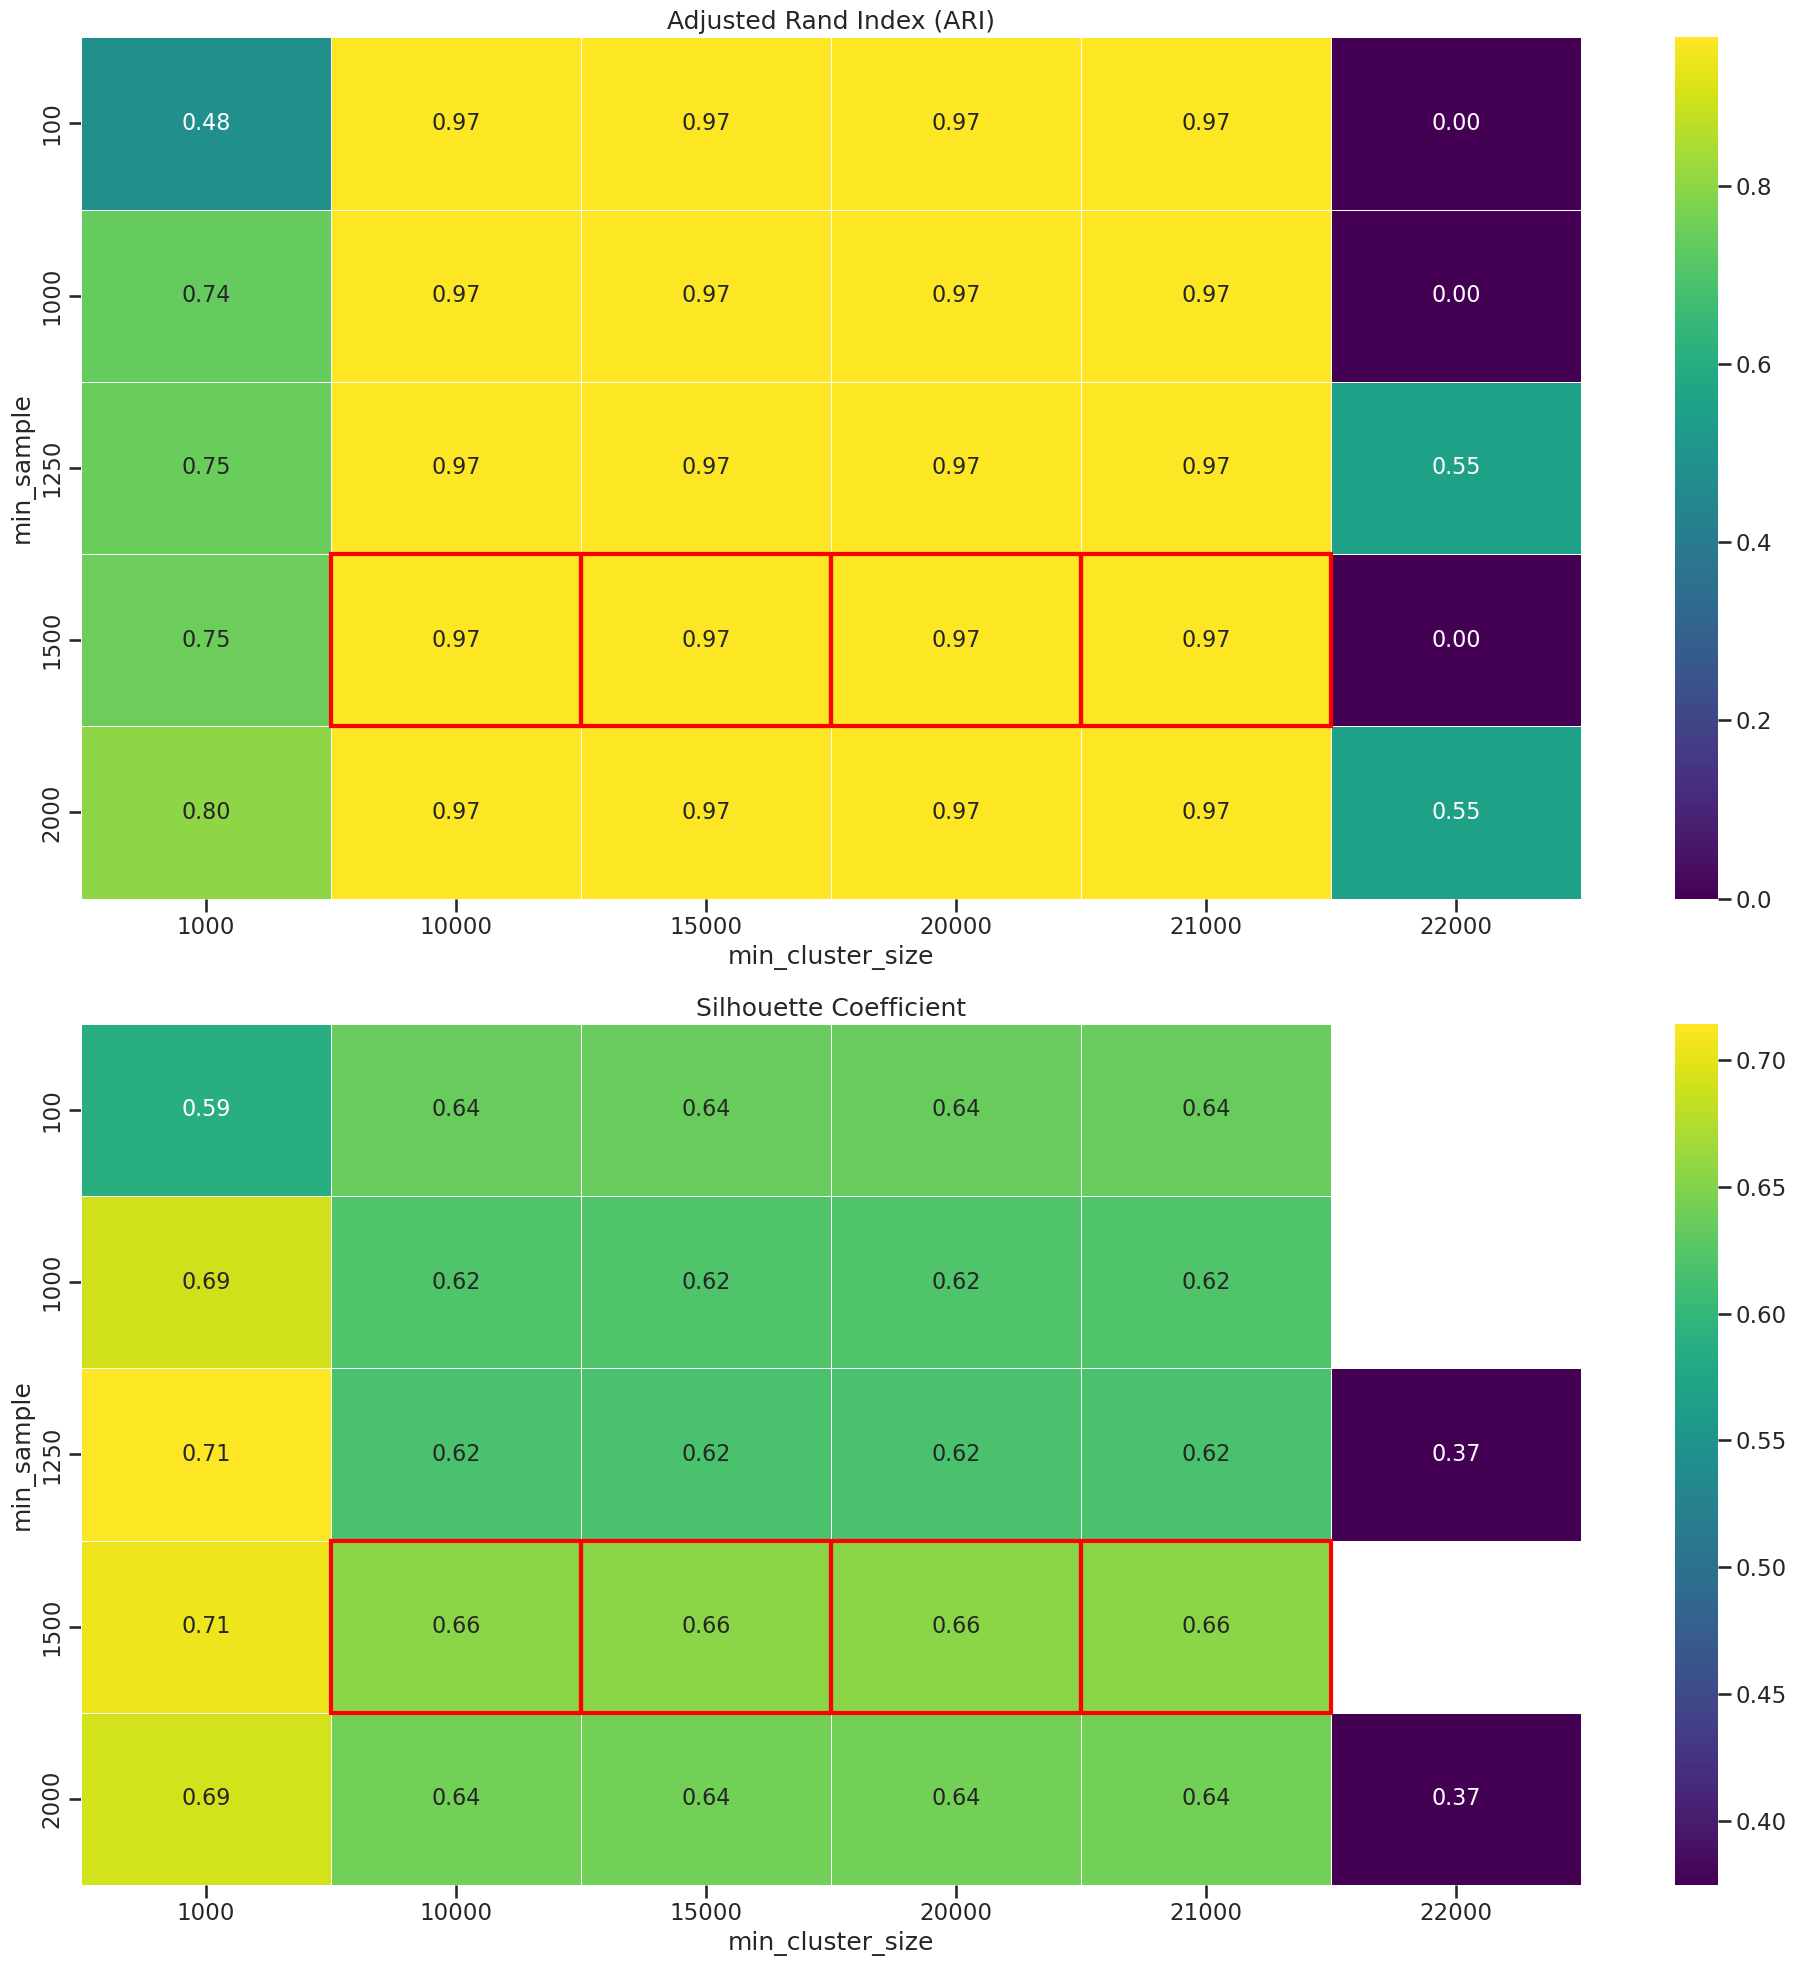

In [ ]:
ari_sc_heatmap(embedding_matrix_reduced, info_df)

- 600: min_sample 1500, min_cluster_size 10000: Adjusted Rand Index: 0.97, Silhouette Coefficient: 0.66
- 850: 100, 10000: ari:0.91, sc = 0.66

min_sample 1500, min_cluster_size 10000: Adjusted Rand Index: 0.97, Silhouette Coefficient: 0.66


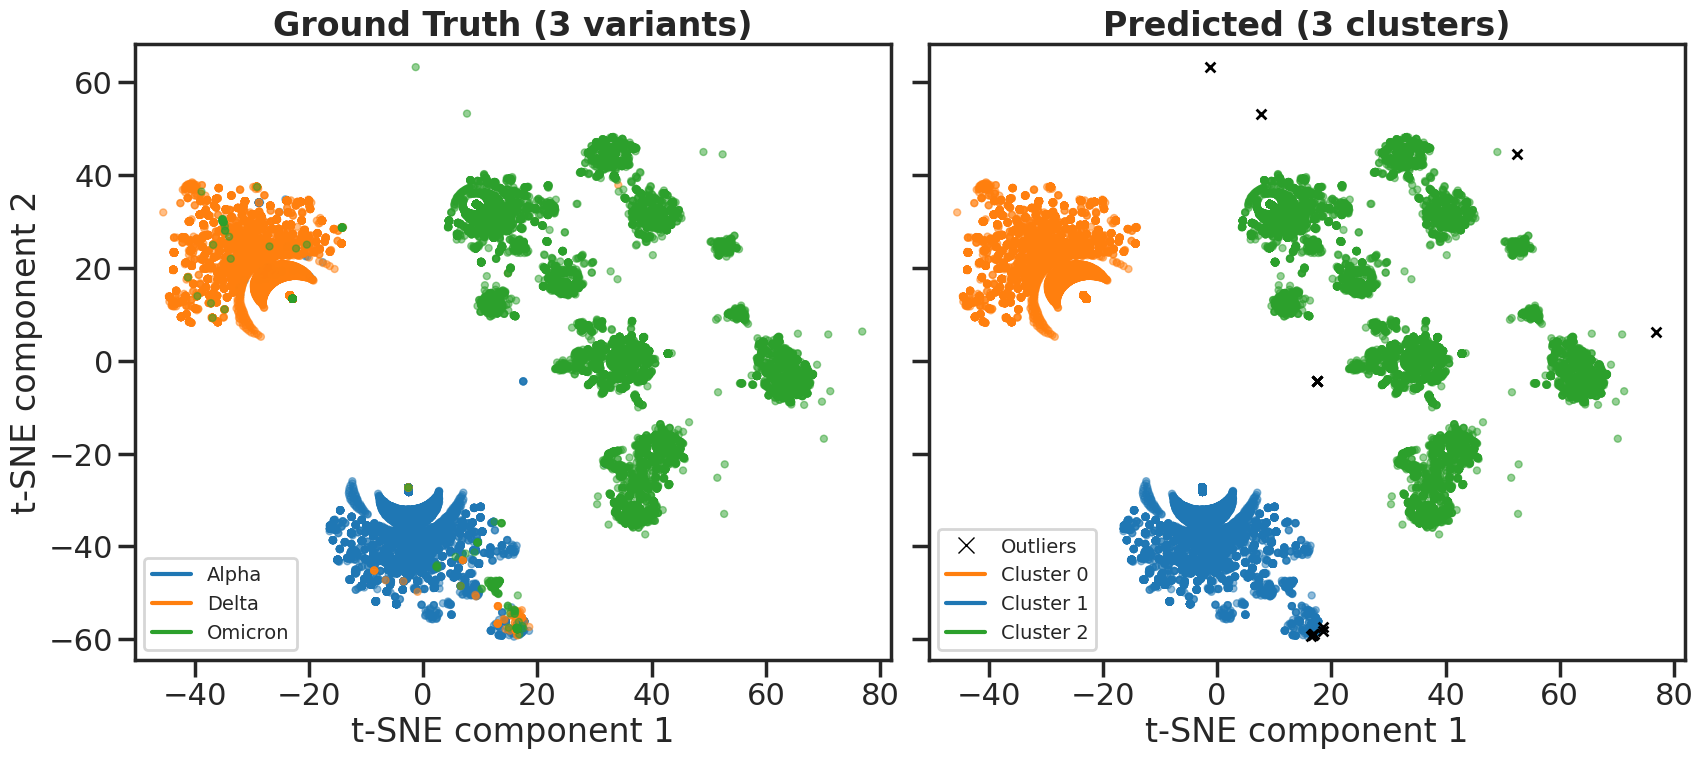

Predicted Clusters,-1,0,1,2
Ground Truth,,,,
Alpha,0.03,0.43,99.45,0.09
Delta,0.01,98.69,1.28,0.03
Omicron,0.02,0.32,1.18,98.48


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_groundtruth_prediction_1x2(embedding_matrix, info_df, hdb_labels, save_as, x_min_width_buffer=2, colormap="colorblind"):
    # Create a DataFrame for easier plotting
    plot_df = pd.DataFrame({
        't-SNE component 1': embedding_matrix[:, 0],
        't-SNE component 2': embedding_matrix[:, 1],
        'Cluster': hdb_labels,
        'Seq ID': info_df['seq_id'],
        'Variant': info_df['variant'],
    })
    marker_size = 25
    
    # Define a variant color palette
    unique_variants = np.unique(plot_df['Variant'])
    variant_color_palette = sns.color_palette(colormap, n_colors=len(unique_variants)) 
    variant_color_dict = {label: color for label, color in zip(unique_variants, variant_color_palette)}

    # Define a cluster color palette
    unique_clusters = np.unique(plot_df['Cluster'])
    cluster_color_palette = sns.color_palette(colormap, n_colors=len(unique_clusters)) 
    cluster_color_palette = [cluster_color_palette[i] for i in [1, 0, 2]]
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_color_palette)}
    cluster_color_dict[-1] = 'black'  # Set outliers to x

    sns.set_style('ticks')
    sns.set_context("poster")
    fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    fig.subplots_adjust(wspace=0.05)  # Reduce the horizontal space between subplots

    #####################################################

    # Scatterplot
    sns.scatterplot(
        data=plot_df,
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Variant', palette=variant_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1,
        ax=axs[0]
    )

    axs[0].set_title(f"Ground Truth ({len(unique_variants)} variants)", ha='center', fontweight='bold')
    axs[0].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+5))
    axs[0].set_ylim(plot_df['t-SNE component 2'].min()-5, plot_df['t-SNE component 2'].max()+5),

    # Legend 
    variant_handles = [
        plt.Line2D([0], [0], color=variant_color_dict[variant], label=f'{variant}')
        for variant in unique_variants
    ]
    axs[0].legend(handles=variant_handles)
    sns.move_legend(axs[0], "lower left", fontsize=14)
    
    # #####################################################

    # Scatterplot for non-outliers
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] != -1],  # Exclude outliers
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Cluster', palette=cluster_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1,
        ax=axs[1]
    )

    # Scatterplot for outliers (Cluster = -1)
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] == -1],  # Select only outliers
        x='t-SNE component 1', y='t-SNE component 2',
        marker='x',
        s=marker_size*2, color='black', linewidth=2,
        ax=axs[1]
    )

    axs[1].set_title(f"Predicted ({len(unique_clusters[unique_clusters != -1])} clusters)", ha='center', fontweight='bold')
    axs[1].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+5))

    # Legend 
    cluster_handles = [plt.Line2D([0], [0], marker='x', color='black', linestyle='none', label='Outliers')]
    cluster_handles += [
        plt.Line2D([0], [0], color=cluster_color_dict[cluster], label=f'Cluster {cluster}')
        for cluster in unique_clusters if cluster != -1
    ]
    axs[1].legend(handles=cluster_handles)
    sns.move_legend(axs[1], "lower left", fontsize=14)

    #####################################################
  
    plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_as}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

min_samples=1500
min_cluster_size=10000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Adjusted Rand Index: {ari:.2f}, Silhouette Coefficient: {silhouette_avg:.2f}")
save_as = f"RBD.ADO.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-ari{ari:.2f}_sc{silhouette_avg:.2f}"

# Call the function
plot_groundtruth_prediction_1x2(embedding_matrix_reduced, info_df, hdb_labels, save_as, x_min_width_buffer=5, colormap="tab10")

# Create the truth table
truth_table_percent = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'],
                                normalize='index')  # Normalize along the index (rows)
truth_table_percent = (truth_table_percent * 100).round(2)
truth_table_percent

In [25]:
# Cluster info
info_df['Cluster'] = hdb_labels
result = cluster_pango_lineage(info_df, 5)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

   Cluster  variant Pango lineage  Cluster %  Lineage %
0       -1    Alpha        B.1.1*  50.000000   0.032325
1       -1    Delta         AY.44   7.142857   0.097561
2       -1    Delta         AY.52   7.142857  11.111111
3       -1  Omicron          BA.2   7.142857   0.051546
4       -1  Omicron          BF.5   7.142857   0.308642

   Cluster variant Pango lineage  Cluster %  Lineage %
0        0   Delta          AY.4  13.115576  99.550484
1        0   Delta      B.1.617*   7.184183  98.255452
2        0   Delta        AY.122   6.382397  97.359277
3        0   Delta        AY.103   5.548722  98.146656
4        0   Delta         AY.43   4.655824  98.743961

   Cluster  variant Pango lineage  Cluster %   Lineage %
0        1    Alpha        B.1.1*  95.256935   98.956361
1        1    Alpha           Q.3   0.857930   98.974359
2        1    Alpha           Q.1   0.537873  100.000000
3        1    Alpha           Q.4   0.506757   98.275862
4        1  Omicron    Unassigned   0.324502   